# Word2Vec
> pip install gensim

In [1]:
!pip show gensim

Name: gensim
Version: 3.8.3
Summary: Python framework for fast Vector Space Modelling
Home-page: http://radimrehurek.com/gensim
Author: Radim Rehurek
Author-email: me@radimrehurek.com
License: LGPLv2.1
Location: c:\users\dojun\anaconda3\envs\python38\lib\site-packages
Requires: scipy, smart-open, numpy, six, Cython
Required-by: 


In [2]:
from gensim.models.word2vec import Word2Vec

In [5]:
test='''i love python and dog. i love R you. you love dog and '''

sentences = test.split('. ')  # .을 기준으로 자름
data = [s.split() for s in sentences]
data

[['i', 'love', 'python', 'and', 'dog'],
 ['i', 'love', 'R', 'you'],
 ['you', 'love', 'dog', 'and']]

In [11]:
len(set(test.replace('.','').split(' ')))  # 전체 vocab 갯수

8

In [16]:
model = Word2Vec(data,         # 리스트 형태의 데이터
                 sg=1,         # 0: CBOW, 1: Skip-gram
                 size=5,       # 벡터 크기, 이 값에 따라 아래의 .mv에 표시되는 숫자갯수가 결정됨
                 window=1,     # 고려할 앞뒤 폭(앞뒤 1단어) 
                 min_count=2,  # 사용할 단어의 최소 빈도(2회 이하 단어 무시)
                 workers=1)    #  동시에 처리할 작업 수(코어 수와 비슷하게 설정), 자신의 컴퓨터에 따라서, 병렬처리가능할때만 숫자높임

In [17]:
print(model)

Word2Vec(vocab=5, size=5, alpha=0.025)


In [18]:
model.wv.vocab

{'i': <gensim.models.keyedvectors.Vocab at 0x25e4df184c0>,
 'love': <gensim.models.keyedvectors.Vocab at 0x25e4df185b0>,
 'and': <gensim.models.keyedvectors.Vocab at 0x25e4df18280>,
 'dog': <gensim.models.keyedvectors.Vocab at 0x25e4df182e0>,
 'you': <gensim.models.keyedvectors.Vocab at 0x25e4df18a00>}

In [19]:
vocab = list(model.wv.vocab)
print(vocab)

x = model.wv[vocab]
print(x)

['i', 'love', 'and', 'dog', 'you']
[[ 0.02558318 -0.03024592  0.08704678  0.08831441 -0.01369626]
 [ 0.03044671 -0.09306611 -0.08398461 -0.03688921 -0.04937231]
 [-0.06175141 -0.09689398  0.00459361 -0.02312799  0.08447398]
 [ 0.02923893 -0.09413538 -0.07565939 -0.09754533  0.01044584]
 [-0.04887146 -0.03654332  0.00874839 -0.05651527  0.08060285]]


In [20]:
model.wv.similarity('dog', 'love')

0.8433014

In [21]:
# 코사인 유사도 직접 계산

from numpy import dot
from numpy.linalg import norm
import numpy as np

def cos_sim(A, B):
       return dot(A, B)/(norm(A)*norm(B))
    
cos_sim(x[3], x[1])

0.8433014

# 파이토치로 word2vec 구현하기

In [23]:
!pip show torch

Name: torch
Version: 1.7.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: c:\users\dojun\anaconda3\envs\python38\lib\site-packages
Requires: typing-extensions, numpy
Required-by: torchtext, OpenNMT-py


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

- 데이터셋 준비

In [5]:
sentences = ['i like dog', 'i like cat', 'i like animal',
            'dog cat animal', 'apple cat dog like', 'dog fich milk lilke',
            'dog cat eyes like', 'i like apple', 'apple i hate',
            'apple i movie book music like', 'cat dog hate', 'cat dog like']

word_sequence = ' '.join(sentences).split()
word_list = list(set(word_sequence))
word_list.sort()
word_dict = {w: i for i, w in enumerate(word_list)}  # key: 단어, value: 인덱스

print(word_dict)

{'animal': 0, 'apple': 1, 'book': 2, 'cat': 3, 'dog': 4, 'eyes': 5, 'fich': 6, 'hate': 7, 'i': 8, 'like': 9, 'lilke': 10, 'milk': 11, 'movie': 12, 'music': 13}


- 하이퍼파라미터 설정

In [6]:
dtype = torch.FloatTensor
batch_size = 20      
embedding_size = 2   # to show 2 dim embedding graph
voc_size = len(word_list)

voc_size

14

- 함수 생성

In [9]:
def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)
    
    for i in random_index:
        random_inputs.append(np.eye(voc_size)[data[i][0]])  # target
        random_labels.append(data[i][1])  # context word
        
    return random_inputs, random_labels

- 스킵 그램

In [10]:
skip_grams = []
for i in range(1, len(word_sequence)-1):
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i-1]], word_dict[word_sequence[i+1]]]
    
    for w in context:
        skip_grams.append([target, w])

- 모델 클래스 생성

In [16]:
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()
        
        # W and WT are not Transpose relationship?
        self.W = nn.Parameter(-2 * torch.rand(voc_size, embedding_size) + 1).type(dtype)  # voc_size > embedding_size Weight
        self.WT = nn.Parameter(-2 * torch.rand(embedding_size, voc_size) + 1).type(dtype) # embedding_size > voc_size weight
        
    def forward(self, X):
        # X: [batch_size, voc_size]
        hidden_layer = torch.matmul(X, self.W)
        output_layer = torch.matmul(hidden_layer, self.WT)
        return output_layer

In [52]:
model = Word2Vec()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

- 모델 트레이닝

In [53]:
weights = []
for epoch in range(1, 5+1):
    
    input_batch, target_batch = random_batch(skip_grams, batch_size)
    
    input_batch = Variable(torch.Tensor(input_batch))
    target_batch = Variable(torch.LongTensor(target_batch))
    
    optimizer.zero_grad()
    output = model(input_batch)
    
    loss = criterion(output, target_batch)
    
    # 가중치 저장
    W, WT = model.parameters()
    weights.append(W)

    print('Epoch:', '%04d' % (epoch), 'cost =', '{:.6f}'.format(loss))
        
    loss.backward()
    optimizer.step()

Epoch: 0001 cost = 2.869294
Epoch: 0002 cost = 2.771325
Epoch: 0003 cost = 2.813146
Epoch: 0004 cost = 2.716756
Epoch: 0005 cost = 2.821321


- 그래프 출력

In [39]:
print(len(weights))
weights[0]

5


Parameter containing:
tensor([[-0.6328,  0.0591],
        [-0.0259,  0.3684],
        [ 0.3692,  0.6471],
        [ 0.5916,  0.4447],
        [ 0.6493,  0.4705],
        [ 0.7657, -0.0744],
        [-0.1173, -0.8156],
        [ 0.3490, -0.1985],
        [-0.2792, -0.0379],
        [-0.9371, -0.7405],
        [-0.2058, -0.0043],
        [-0.7806, -0.5344],
        [ 0.8863,  0.6182],
        [-0.9116,  0.9216]], requires_grad=True)

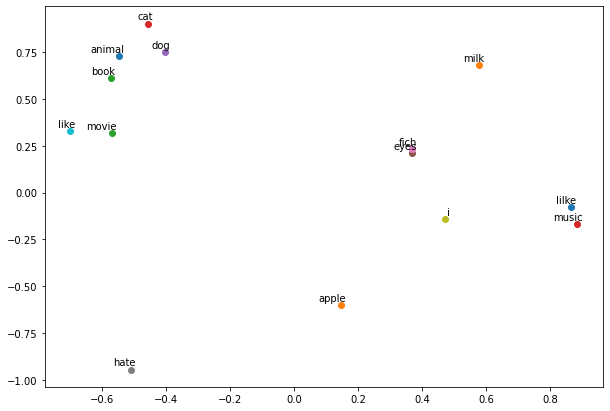

In [67]:
num = 4
W = weights[num]
plt.figure(figsize=(10, 7))

for i, label in enumerate(word_list):
    x, y = float(W[i][0]), float(W[i][1])
    
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    
plt.savefig('./deeplearning/word2vec/epoch'+str(num)+'.png')
plt.show()